### Demo for making gene panels using two methods, mFISHtools and geneBasis with evaluation using scrattch-mapping

In [1]:
# import some stuff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
from sawg.expression_dataset import ExpressionDataset, GenePanelSelection, mFISHtoolsMethod, GeneBasisMethod
from sawg.celltype_mapping import ScrattchMapping

Identify a directory to save gene panels and load reference taxonomy

In [2]:
directory = '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/'

In [3]:
ai115_tax = ad.read_h5ad('//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115/NHP_BG_AIT115_taxonomy.h5ad')

## mFISHtools Example

#### Make ExpressionDataset

In [4]:
exp_data = ExpressionDataset(
    expression_data= ai115_tax,
    save_path = directory, # path to save to for later recall
    expression_type = 'logcpm',
    region = 'AIT11.5',
    # subsample to 100 cells per cluster for smaller files and faster processing
    target_cells = 100,
    target_label = 'Cluster'
)

gene panel UID: 1691622658.990


In [3]:
## if you have already made an expression dataset and know the UID you can load it like this:

# exp_data = ExpressionDataset.load_from_timestamp(directory=directory, timestamp='1691622658.990')

#### Create mFISHtools method

In [5]:
mfishtools = mFISHtoolsMethod(exp_data=exp_data)

In [6]:
# we often want to start with a particular list of genes

starter_genes = ['DRD1', 'DRD2', 'CHAT', 'MEIS2', 'CHODL', 'TAC3', 'VIP', 'ETNPPL']

# we also want to filter the genes in exp_data to those that have variable expression per cell type
# mFISHtools implements this by identifying binary genes. We will instruct mFISHtools to pick the top 3000 binary genes

mfishtools.filter_genes(starting_genes=starter_genes, num_binary_genes=3000) # this creates entries in the uns field to feed to mFISHtools

#### Create HPC job

Default parameters

```hpc_args.get('job_path', None)  

hpc_default = {  
    'hpc_host': 'hpc-login',  
    'job_path': job_path,  
    'partition': 'celltypes',  
    'job_name': 'mfishtools',  
    'nodes': 1,  
    'mincpus': 10,  
    'mem': '500G',  
    'time':'24:00:00',  
    'mail_user': None,  
    'output': job_path + 'hpc_logs/%j.out',  
    'error': job_path + 'hpc_logs/%j.err',  
}```

In [7]:
docker = 'singularity exec /allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/scrattch_mapping_0.2.sif'

hpc_args = {
    'job_path': directory, # job path is where the R-script should be
    'time': '5:00:00'
}

job = mfishtools.select_gene_panel(
    size=50, # identify how big you want your panel to be
    cluster_label='Cluster', # mFISHtools needs this to know what annotations to use for optimization
    docker= docker,
    hpc_args=hpc_args
)
# this will return the HPC job ID which you can use to see the status. If job.state() returns NO_INFO the job has stopped

building temp ad_h5ad
building HPC job
<JobState PENDING> 10757604


In [12]:
job.state()

<JobState RUNNING>

In [13]:
job.state()

<JobState NO_INFO>

#### Load gene_list.csv exported from mFISHtools as GenePanelSelection object

In [8]:
mfishtools_panel = mfishtools.load_gene_panel()
mfishtools_panel

deleting mfishtools temp file...


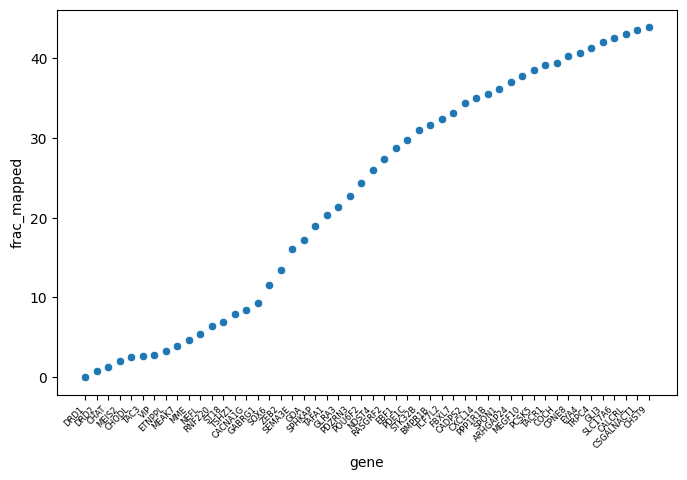

In [9]:
## mFISHtools calculates the fraction of correctly mapped cells as you add each gene. That is stored in the `args` field of the
## GenePanelSelection object. You can plot that as such

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=mfishtools_panel.args['frac_mapped'], x='gene', y='frac_mapped',ax=ax)
_ = ax.set_xticklabels(mfishtools_panel.args['frac_mapped']['gene'], fontsize=6, rotation=45, ha='right')

In [5]:
## If you have already made a GenePanelSelection and know the UID (same as the associated ExpressionDataset) you can load it 
## like this:

# mfishtools_panel = GenePanelSelection.load_from_timestamp(directory=directory, timestamp='1691622658.990')

#### Create an evaluation method. In this case we will use scrattch-mapping

ScrattchMapping class requires inputs for the spatial data to map (in this case we will use the ExpressionDataset reduced to the set of genes returned in the gene panel) and a path to the reference taxonomy used for mapping. The workflow below is the same as if you wanted to use the ScrattchMapping Class to map actual spatial data

In [10]:
mfishtools_panel.eval_method(
    method = ScrattchMapping(
        sp_data = mfishtools_panel.exp_data.select_genes(mfishtools_panel.gene_panel).expression_data,
        taxonomy_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115/',
    )
)

#### Similar to above, run scrattch-mapping on the HPC

In [11]:
ad_map_args = {'save_path': directory}
hpc_args = {
    'job_path': '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/mapping/',
    'output': directory + 'hpc_logs/%j.out',
    'error': directory + 'hpc_logs/%j.err',
}
docker = 'singularity exec /allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/scrattch_mapping_0.2.sif'

job = mfishtools_panel.eval.run_on_hpc(ad_map_args, hpc_args, docker=docker)

probe type not set in ad_sp.var, assuming only genes in ad_sp.var...
building HPC job
<JobState PENDING> 10769556


#### load mapping results and plot stuff

In [14]:
mfishtools_panel.eval.load_scrattch_mapping_results()

loading results...
analysis UID: 1691622658.990
deleting scrattch-mapping temp file...


<AxesSubplot: xlabel='score.Corr', ylabel='Count'>

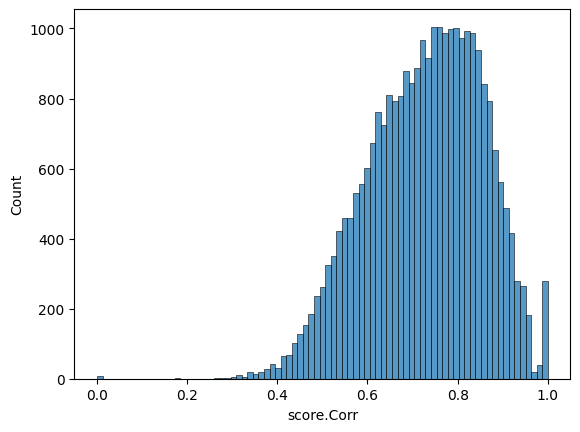

In [15]:
## First we can look at the distribution of mapping scores

sns.histplot(mfishtools_panel.eval.ad_map.obs['score.Corr'])

In [16]:
## Create confusion matrices. We first have to restructure the AnnData obs dataframe appropriately to create a pivot table with
## annotated cell type labels from the taxonomy on the columns and mapped cell type labels on the rows. We then normalize it so
## that the values in the matrix are the fraction of correctly mapped cells

pivot_cols = {
    'cluster': ['Cluster', 'cluster_Corr'], # these column names might change depending on what hierarchy levels you have and the names of the columns
    'subclass': ['Subclass', 'level3.subclass_Corr'],
    'neighborhood': ['Neighborhood', 'level2.neighborhood_Corr'],
    'class': ['Class', 'level1.class_Corr']
}

norm_conf_matrix = mfishtools_panel.eval.get_confusion_matrix(pivot_cols)
## norm_conf_matrix is a multilevel dataframe where each level is a cell type hierarchy level

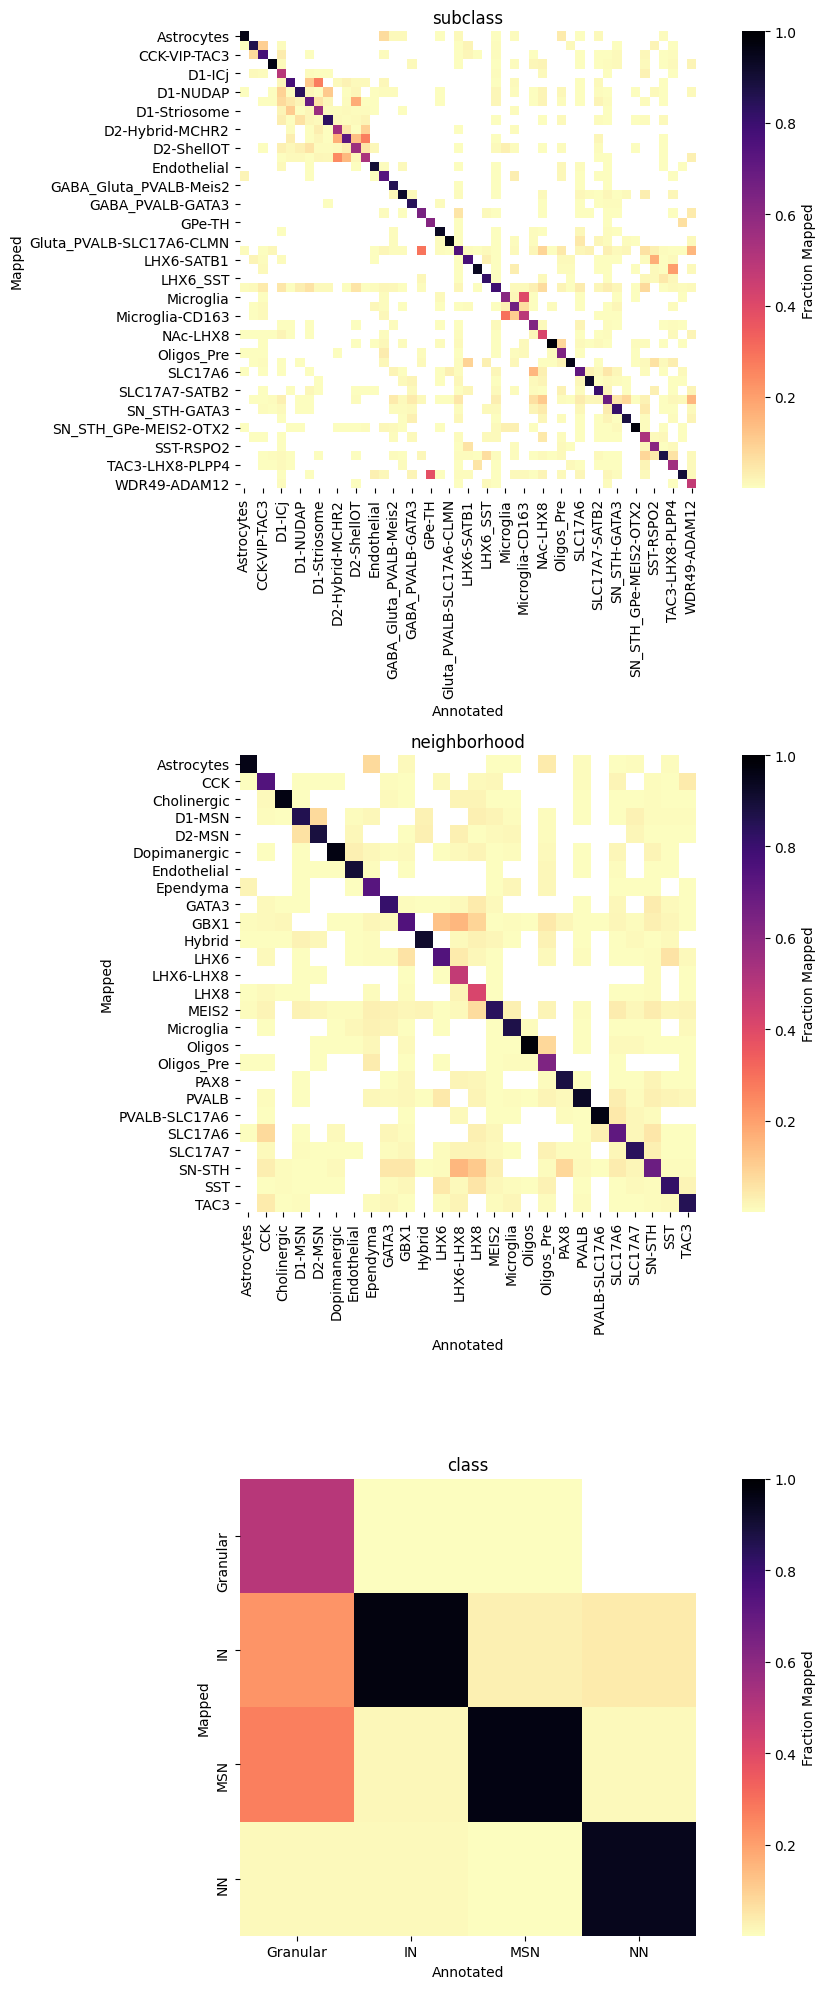

In [17]:
## plot confusion matrices for subclass, neighborhood, and class levels

fig, ax = plt.subplots(3, 1, figsize=(10, 20))
                    
for i, level in enumerate(['subclass', 'neighborhood', 'class']):
    matrix = norm_conf_matrix[level].dropna(how='all')
    matrix = matrix.loc[matrix.columns]
    matrix.index.name = 'Mapped'
    sns.heatmap(matrix, cmap='magma_r', vmax=1, ax=ax[i], square=True,cbar_kws={'label': 'Fraction Mapped'})
    ax[i].set_title(level)
plt.tight_layout()

From this we can say that we need more genes to identify the Granular class that distinguishes it from MSN and IN classes

In [ ]:
## Similar to above, once you have created and saved a CellTypeMapping object you can recall it

# mfishtools_panel.eval = ScrattchMapping.load_from_timestamp(directory=directory, timestamp='1691622658.990')

## geneBasis Example

The workflow is the same but with some tweaks to work with the particulars of geneBasis

#### Make a new ExpressionDataset

In [18]:
exp_data2 = ExpressionDataset(
    expression_data= ai115_tax,
    save_path = directory, # path to save to for later recall
    expression_type = 'logcpm',
    region = 'AIT11.5',
    # subsample to 100 cells per cluster for smaller files and faster processing
    target_cells = 100,
    target_label = 'Cluster'
)

gene panel UID: 1691688866.439


#### Make geneBasis Method

In [20]:
gene_basis = GeneBasisMethod(exp_data=exp_data2)

In [21]:
# select starting genes

starter_genes = ['DRD1', 'DRD2', 'CHAT', 'MEIS2', 'CHODL', 'TAC3', 'VIP', 'ETNPPL']

# filter to highly variable genes as identified in the ExpressionDataset taxonomy
# slight difference here from mFISHtools where we need to feed it a list of highly variable genes to reduce the search to 

hvgs = gene_basis.exp_data.expression_data.var[gene_basis.exp_data.expression_data.var['highly_variable']==True]['gene'].to_list()

gene_basis.filter_genes(starting_genes=starter_genes, hvgs=hvgs)

#### Create HPC job

In [22]:
# default docker: '/allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/genebasis.sif'

hpc_args = {
    'job_path': directory,
    'time': '5:00:00'
}

# geneBasis takes csv files of expression data and annotations as input so under the hood the first step is to export the 
# ExpressionDataset anndata to csv files. If these already exist in the run_directory they those will be used.

job = gene_basis.select_gene_panel(
    size=50, 
    panel_args={'genes_base': starter_genes}, # geneBasis dumps these argmuments into a json for ingest in the R-script
    hpc_args=hpc_args,
)

saving expression and annotation data to csv...
building HPC job
<JobState PENDING> 10769978


#### Load gene_list.csv exported from geneBasis as GenePanelSelection object

In [23]:
gene_basis_panel = gene_basis.load_gene_panel()

#### Evaluate the panel as we did above with scrattch-mapping

In [24]:
gene_basis_panel.eval_method(
    method = ScrattchMapping(
        sp_data = gene_basis_panel.exp_data.select_genes(gene_basis_panel.gene_panel).expression_data,
        taxonomy_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115/',
    )
)

In [25]:
ad_map_args = {'save_path': directory}
hpc_args = {
    'job_path': '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/mapping/',
    'output': directory + 'hpc_logs/%j.out',
    'error': directory + 'hpc_logs/%j.err',
}
docker = 'singularity exec /allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/scrattch_mapping_0.2.sif'

job = gene_basis_panel.eval.run_on_hpc(ad_map_args, hpc_args, docker=docker)

probe type not set in ad_sp.var, assuming only genes in ad_sp.var...
building HPC job
<JobState RUNNING> 10770073


In [26]:
gene_basis_panel.eval.load_scrattch_mapping_results()

loading results...
analysis UID: 1691688866.439
deleting scrattch-mapping temp file...


<AxesSubplot: xlabel='score.Corr', ylabel='Count'>

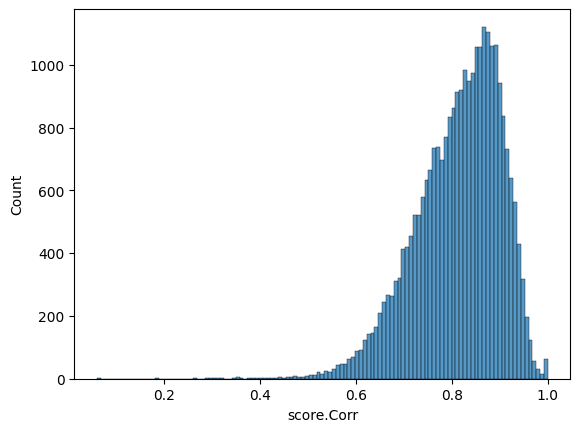

In [27]:
sns.histplot(gene_basis_panel.eval.ad_map.obs['score.Corr'])

In [28]:
pivot_cols = {
    'cluster': ['Cluster', 'cluster_Corr'], # these column names might change depending on what hierarchy levels you have and the names of the columns
    'subclass': ['Subclass', 'level3.subclass_Corr'],
    'neighborhood': ['Neighborhood', 'level2.neighborhood_Corr'],
    'class': ['Class', 'level1.class_Corr']
}

norm_conf_matrix = gene_basis_panel.eval.get_confusion_matrix(pivot_cols)

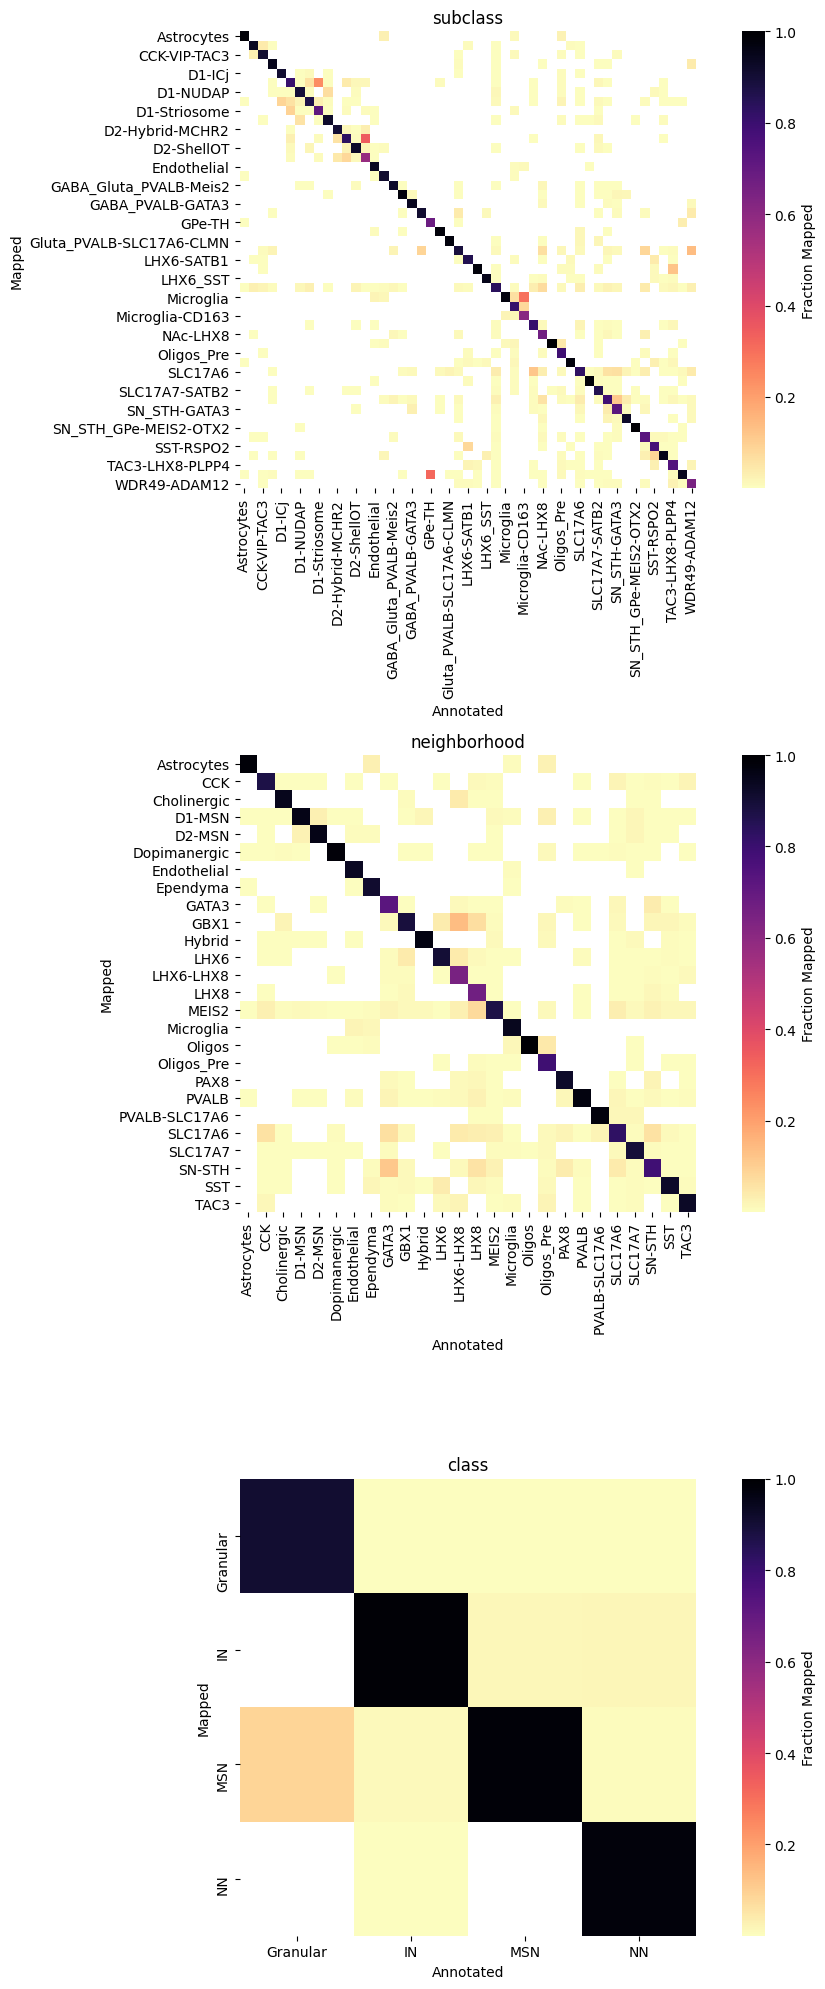

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
                    
for i, level in enumerate(['subclass', 'neighborhood', 'class']):
    matrix = norm_conf_matrix[level].dropna(how='all')
    matrix = matrix.loc[matrix.columns]
    matrix.index.name = 'Mapped'
    sns.heatmap(matrix, cmap='magma_r', vmax=1, ax=ax[i], square=True,cbar_kws={'label': 'Fraction Mapped'})
    ax[i].set_title(level)
plt.tight_layout()

#### If you are interested in evaluating a panel with the mFISHtools utility of fraction correctly mapped by gene, you can do that manually like this

In [30]:
from sawg.expression_dataset import run_mfishtools_fraction_mapped, load_mfishtools_fraction_mapped

hpc_args = {
    'job_path': directory,
    'docker': 'singularity exec /allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/scrattch_mapping_0.2.sif',
    'time': '5:00:00'
}

job = run_mfishtools_fraction_mapped(gene_basis_panel, cluster_label='Cluster', hpc_args=hpc_args)

building HPC job
<JobState PENDING> 10770082


In [31]:
load_mfishtools_fraction_mapped(gene_basis_panel)

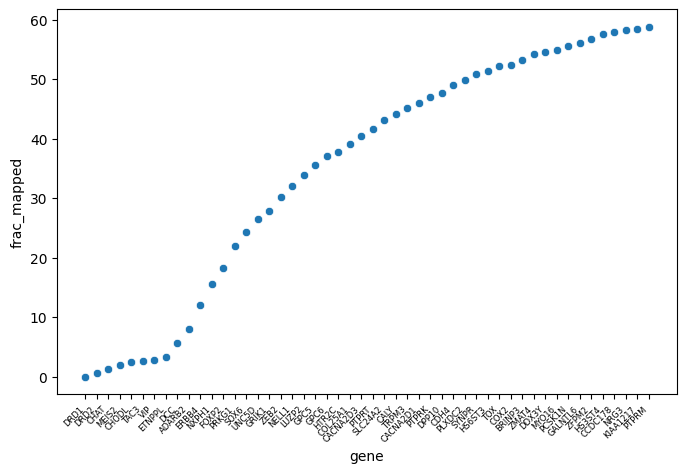

In [32]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=gene_basis_panel.args['frac_mapped'], x='gene', y='frac_mapped',ax=ax)
_ = ax.set_xticklabels(gene_basis_panel.args['frac_mapped']['gene'], fontsize=6, rotation=45, ha='right')